#LAB-2: Classification using KNN, RF, MLP

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


In [4]:
digits = load_wine()
wine_data = load_wine(as_frame=True)
wine_df = wine_data.frame
print(wine_df.head())

# Display the shape of the DataFrame
print("Shape of the Wine DataFrame:", wine_df.shape)

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0          

In [7]:
X = digits.data
y = digits.target

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [9]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

knn_param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 13, 15, 20]}

In [10]:
rf_pipeline = Pipeline([
    ("rf", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    "rf__n_estimators": [25, 50, 100, 200, 500],
    "rf__max_depth": [None, 10, 20]}


In [11]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ))
])

mlp_param_grid = {
    "mlp__hidden_layer_sizes": [(64,), (128,), (64, 64)],
    "mlp__activation": ["relu", "tanh"],
    #"mlp__alpha": [0.0001, 0.001],
    "mlp__learning_rate_init": [0.001, 0.01, 1.0, 5.0, 10.0]
}


In [12]:
#Training the model
def train_with_timing(pipeline, param_grid):
    start = time.time()
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring="f1_weighted",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    train_time = time.time() - start
    return grid, train_time

knn_grid, knn_train_time = train_with_timing(knn_pipeline, knn_param_grid)
rf_grid, rf_train_time = train_with_timing(rf_pipeline, rf_param_grid)
mlp_grid, mlp_train_time = train_with_timing(mlp_pipeline, mlp_param_grid)


In [13]:
#Inferencing the model
def inference_time(model):
    start = time.time()
    model.predict(X_test)
    return time.time() - start

knn_test_time = inference_time(knn_grid.best_estimator_)
rf_test_time = inference_time(rf_grid.best_estimator_)
mlp_test_time = inference_time(mlp_grid.best_estimator_)

In [14]:
#Evaluation
def evaluate_model(model):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-score": f1_score(y_test, y_pred, average="weighted")
    }

knn_metrics = evaluate_model(knn_grid.best_estimator_)
rf_metrics = evaluate_model(rf_grid.best_estimator_)
mlp_metrics = evaluate_model(mlp_grid.best_estimator_)

In [15]:
#Result with comparison
results_df = pd.DataFrame(
    [knn_metrics, rf_metrics, mlp_metrics],
    index=["KNN", "Random Forest", "MLP"]
)

results_df["Training Time (s)"] = [
    knn_train_time, rf_train_time, mlp_train_time
]

results_df["Inference Time (s)"] = [
    knn_test_time, rf_test_time, mlp_test_time
]

print(results_df)

               Accuracy  Precision    Recall  F1-score  Training Time (s)  \
KNN            0.955556   0.958654  0.955556  0.955051           3.093626   
Random Forest  1.000000   1.000000  1.000000  1.000000           3.232798   
MLP            0.866667   0.876429  0.866667  0.863112           0.603219   

               Inference Time (s)  
KNN                      0.006953  
Random Forest            0.002274  
MLP                      0.000788  


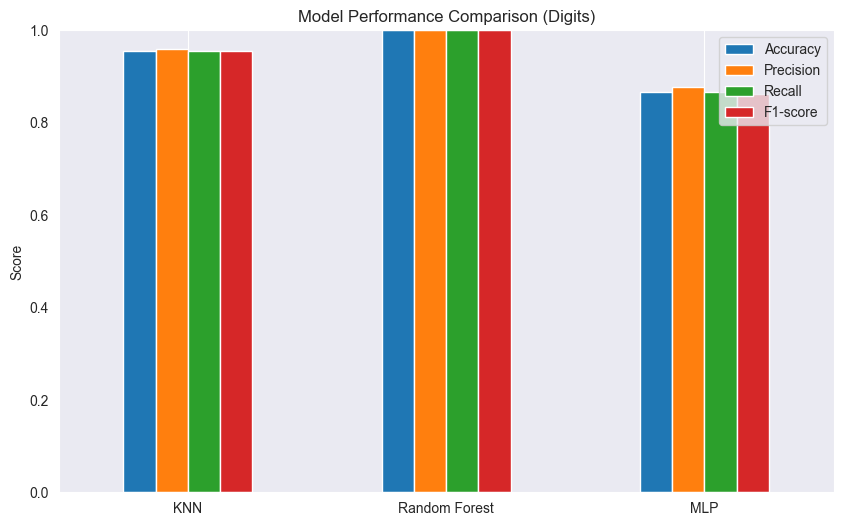

In [16]:
results_df.iloc[:, :4].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison (Digits)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

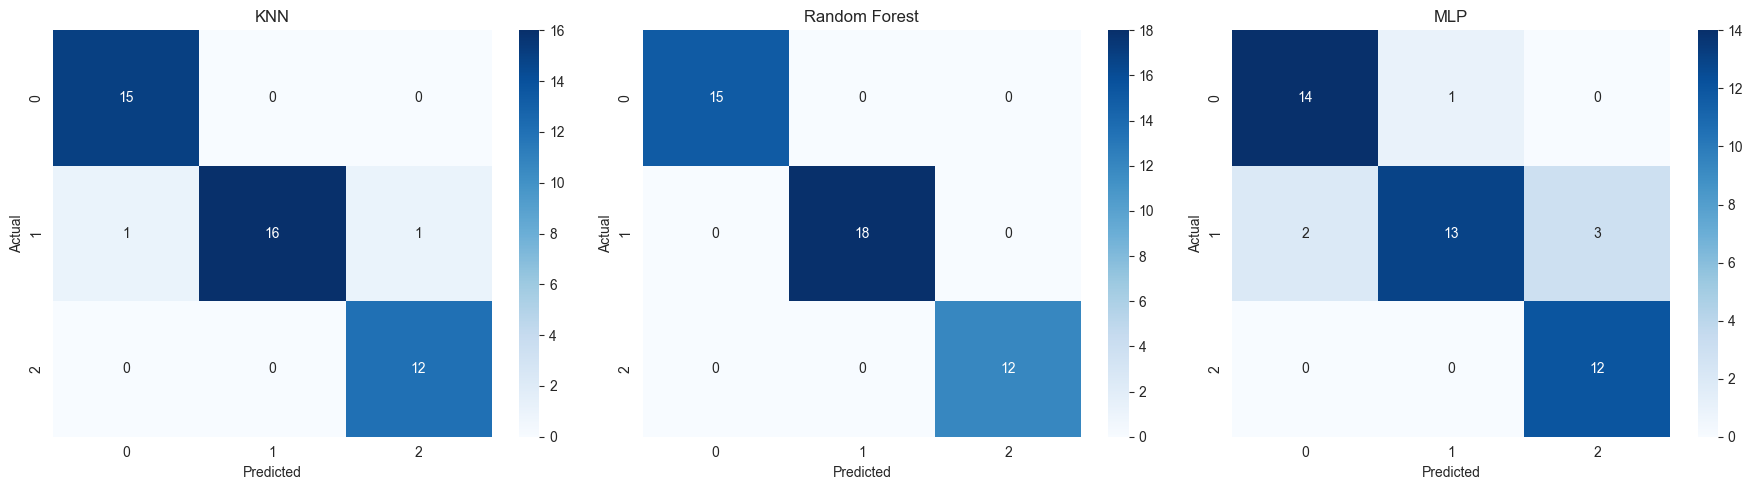

In [17]:
models = {
    "KNN": knn_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "MLP": mlp_grid.best_estimator_
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()